In [4]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, NLocal, PauliTwoDesign
# from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD # chemistry simulation ansatzes, for example the UCCSD ansatz prepares a state where tuning the parameters turns excitations on and off
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
import numpy as np 
from numpy import sqrt, pi, linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import sqrtm
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.result import marginal_counts
from IPython.display import display, clear_output
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, execute
IBMQ.load_account()
provider = IBMQ.get_provider(group='open', project='main')

In [35]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "ZZ": # Measure two Pauli Z 
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Z":# Measure one Pauli Z 
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "X": # Measure one Pauli X
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    elif gate == "YY": # Measure two Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y": # Measure one Pauli Y
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    return firesult

def Expectation_backend(gate=None,q1=None,q2=None,circ=None,realbackend=Aer.get_backend('qasm_simulator')):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    
    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    backend = realbackend
    shot=20000
    
    # Get string of state
    qubit = qc.num_qubits
    bitq1 = '' # Get string of |...01...> state
    bitq2 = '' # Get string of |...10...> state
    bit0 = ''  # Get string of |...00...> state
    for i in range(qubit):
        bit0 += '0'
        if i == q1:
            bitq1 += '1'
            bitq2 += '0'
        elif i == q2:
            bitq2 += '1'
            bitq1 += '0'
        else:
            bitq1 += '0'
            bitq2 += '0'
    bit0 = bit0[::-1]
    bitq1 = bitq1[::-1]
    bitq2 = bitq2[::-1]
    
    if gate == "ZZ":
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Z":
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    elif gate == "YY":
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.sdg(q2) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q2) # Apply H gate to apply X basic measurement
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "Y":
        qc.sdg(q1) # Apply Sdg gate to transform from X basic to Y basic measurement
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    return firesult

In [36]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

In [40]:
def vqe_exact(qc, parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("ZZ",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton 

In [41]:
def vqe_backend(qc,parameter, q,h, file=None):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    # # qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

        # File write
        if file == None:
            continue
        else:
            file.write(f'Parameter: {parameter} \n ')
            file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

In [42]:
def FiniteDiff_exact(q,h,qc,parameters, epsilon = 1e-3 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff [i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_backend(qc, [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_backend(qc,[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [43]:
def FiniteDiff_QN_SPSA(q,h,qc,parameters, epsilon = 1e-2 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    g = np.zeros([len(parameters),len(parameters)])
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        fix_parameters = [0 for i in range(len(parameters))]
        for i in range(len(parameters)):
            fix_parameters[i] = parameters[i]
        for i in range(len(parameters)):
            finite_diff = [0 for i in range(len(parameters))]
            finite_diff [i] = epsilon

            Dvqe[i] = (1/(2*epsilon)*(vqe_backend(qc, [fix_parameters[i] + finite_diff[i] for i in range(len(fix_parameters))],q,h)-vqe_backend(qc,[fix_parameters[i] - finite_diff[i] for i in range(len(fix_parameters))],q,h)))
        
        # Get the QN_SPSA
        g = QN_SPSA(qc,parameters,g,Nth_iter=j)
        # Pseudo-inverse
        g_1 = linalg.pinv(g)
        # Update papramter
        for i in range(len(parameters)):
            for j in range(len(parameters)):
                parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [44]:
def SPSA_exact(q,h,qc,parameters, epsilon = 0.15 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
        spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(len(parameters)):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
            parameters[i]-=l_rate*Dvqe[i]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [45]:
def SPSA_QN_SPSA(q,h,qc,parameters, epsilon = 0.01 ,l_rate=0.01, ite = 100):
    Deriva = [[0] for i in range(qc.num_parameters)]
    Upd_para = [[0] for i in range(qc.num_parameters)]
    vqe = []
    q = qc.num_qubits
    num_parameters = qc.num_parameters
    g = np.zeros([len(parameters),len(parameters)])
    gk_1 = np.zeros([len(parameters),len(parameters)])
    for j in range(ite):
        Dvqe = [0 for i in range(len(parameters))]
        # Perturbation vector
        per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
        spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
        for i in range(len(parameters)):

            Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
        # Get the QN_SPSA
        g = QN_SPSA(qc,parameters,g,Nth_iter=j)
        # Pseudo-inverse
        print(g)
        g_1 = linalg.pinv(g)
        print(parameters)
        print(g_1) 
        # Update papramter
        for i in range(len(parameters)):
            for j in range(len(parameters)):
                parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
            Upd_para[i].append(parameters[i])
            Deriva[i].append(Dvqe[i])
        vqe.append(vqe_backend(qc, parameters,q,h))
    return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [46]:
# def SPSA_QN_SPSA(q,h,qc,parameters, epsilon = 0.01 ,l_rate=0.01, ite = 100,beta = 0.001 ,eps = 0.01):
#     Deriva = [[0] for i in range(qc.num_parameters)]
#     Upd_para = [[0] for i in range(qc.num_parameters)]
#     vqe = []
#     q = qc.num_qubits
#     num_parameters = qc.num_parameters
#     g = np.zeros([len(parameters),len(parameters)])
#     gk_1 = np.zeros([len(parameters),len(parameters)])
#     for j in range(ite):
#         Nth_iter = j
#         Dvqe = [0 for i in range(len(parameters))]
#         # Perturbation vector
#         per_vec1 = [np.random.choice([1,-1])*eps for i in range(len(parameters))]
#         per_vec2 = [np.random.choice([1,-1])*eps for i in range(len(parameters))]
#         per_vec = [np.random.choice([1,-1])*epsilon for i in range(len(parameters))]
#         spsa_diff = vqe_backend(qc, np.add(parameters,per_vec),q,h)-vqe_backend(qc,np.subtract(parameters,per_vec),q,h)
#         for i in range(len(parameters)):

#             Dvqe[i] = 1/(2*per_vec[i])*spsa_diff
        
#         # Get the QN_SPSA
#         # Metric tensor
#         # PQC
#         qc1 = qc.assign_parameters(np.add(np.add(parameters,per_vec1),per_vec2))
#         qc2 = qc.assign_parameters(np.add(parameters,per_vec1))
#         qc3 = qc.assign_parameters(np.add(np.add(parameters,[-i for i in per_vec1]),per_vec2))
#         qc4 = qc.assign_parameters(np.add(parameters,[-i for i in per_vec1]))
#         qc0 =  qc.assign_parameters(parameters).inverse()
        
#         # Construct expecation value
#         qc1.append(qc0,[_ for _ in range(q)])
#         qc2.append(qc0,[_ for _ in range(q)])
#         qc3.append(qc0,[_ for _ in range(q)])
#         qc4.append(qc0,[_ for _ in range(q)])

#         # Execute the circuits
#         backend = Aer.get_backend('statevector_simulator')
#         job = execute([qc1,qc2,qc3,qc4], backend) 
#         result = job.result().get_counts()
#         # Get the |000..0> state index
#         index = ''
#         for i in range(q):
#             index += '0'
#         # Get the wanted results from running backend
#         fun = [0]*4
#         for i in range(4):
#             for ind in result[i]:
#                 if ind == index:
#                     fun[i] = result[i][index]
#         # Calculating the shifting value
#         F = [fun[0],-fun[1],-fun[2],fun[3]]
#         F = sum(F)
#         print(parameters)
#         print(g)
#         # QN_SPSA matrix
#         for i in range(q):
#             for j in range(q):
#                 g[i][j]=-1/2*F/(2*eps**4)*(per_vec1[i]*per_vec2[j]+per_vec1[j]*per_vec2[i])/2
#         # The smoothing of the QN_SPSA matrix
#         g = Nth_iter/(Nth_iter+1)*gk_1+1/(Nth_iter+1)*g
#         # Regularization to ensure invertibility (positive semi-definite)
#         g = sqrtm(g.dot(g))+beta*np.identity(num_parameters)
#         # Pseudo-inverse
#         g_1 = linalg.pinv(g) # np.identity(num_parameters)
#         gk_1 = g.copy()
#         # Update papramter
#         for i in range(len(parameters)):
#             for j in range(len(parameters)):
#                 parameters[i]-=l_rate*g_1[i,j]*Dvqe[j]
#             Upd_para[i].append(parameters[i])
#             Deriva[i].append(Dvqe[i])
#         vqe.append(vqe_backend(qc, parameters,q,h))
#         print(parameters)
#     return vqe_exact(qc, parameters,q,h), Deriva, Upd_para, vqe

In [47]:
q = 2
h = 0.8
numberofiteration = 20
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)

In [48]:
parameter = [0.5 for i in range(real.num_parameters)]
result = FiniteDiff_exact(q,h,real,parameter,ite=numberofiteration)

In [49]:
parameter = [0.5 for i in range(real.num_parameters)]
result1 = SPSA_exact(q,h,real,parameter,ite=numberofiteration)

In [50]:
parameter = [0.5 for i in range(real.num_parameters)]
result2 = SPSA_QN_SPSA(q,h,real,parameter,ite=numberofiteration)

[[ 0.06165093 -0.06065093  0.          0.        ]
 [-0.06065093  0.06165093  0.          0.        ]
 [ 0.          0.          0.001       0.        ]
 [ 0.          0.          0.          0.001     ]]
[0.5, 0.5, 0.5, 0.5]
[[ 504.08824502  495.91175498    0.            0.        ]
 [ 495.91175498  504.08824502    0.            0.        ]
 [   0.            0.         1000.            0.        ]
 [   0.            0.            0.         1000.        ]]
[[ 0.08100512 -0.00852701  0.          0.        ]
 [-0.00852701  0.14025036  0.          0.        ]
 [ 0.          0.          0.0015      0.        ]
 [ 0.          0.          0.          0.0015    ]]
[0.5615689699699815, 0.43843103003001804, 8.029999999999927, -7.029999999999926]
[[ 12.42441378   0.75538543   0.           0.        ]
 [  0.75538543   7.1760327    0.           0.        ]
 [  0.           0.         666.66666667   0.        ]
 [  0.           0.           0.         666.66666667]]
[[ 0.14455299 -0.09523425  0. 

In [51]:
parameter = [0.5 for i in range(real.num_parameters)]
result3 = FiniteDiff_QN_SPSA(q,h,real,parameter,ite=numberofiteration)

In [288]:
h = [i for i in range(numberofiteration)]

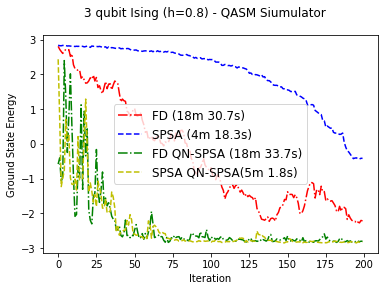

In [292]:
a = 0
b = 200
plt.plot(h[a:b],result[3][a:b],'r-.',label= 'FD (18m 30.7s)')
plt.plot(h[a:b],result1[3][a:b],'b--',label = 'SPSA (4m 18.3s)')
plt.plot(h[a:b],result3[3][a:b],'g-.',label= 'FD QN-SPSA (18m 33.7s)')
plt.plot(h[a:b],result2[3][a:b],'y--',label = 'SPSA QN-SPSA(5m 1.8s)')
plt.legend(loc='best',fontsize='large')
plt.suptitle('3 qubit Ising (h=0.8) - QASM Siumulator')
plt.ylabel('Ground State Energy')
plt.xlabel('Iteration')
plt.show()

In [39]:
def QN_SPSA(qc,parameter,gk_1,Nth_iter,beta = 0.001 ,eps = 0.01):
    q = qc.num_qubits
    num_parameters = qc.num_parameters
    # Metric tensor
    g = np.zeros([num_parameters,num_parameters])
    # Perturbation vector
    per_vec1 = [np.random.choice([1,-1])*eps for i in range(num_parameters)]
    per_vec2 = [np.random.choice([1,-1])*eps for i in range(num_parameters)]
    # PQC
    qc1 = qc.assign_parameters(np.add(np.add(parameter,per_vec1),per_vec2))
    qc2 = qc.assign_parameters(np.add(parameter,per_vec1))
    qc3 = qc.assign_parameters(np.add(np.add(parameter,[-i for i in per_vec1]),per_vec2))
    qc4 = qc.assign_parameters(np.add(parameter,[-i for i in per_vec1]))
    qc =  qc.assign_parameters(parameter).inverse()
    # Construct expecation value
    qc1.append(qc,[_ for _ in range(q)])
    qc2.append(qc,[_ for _ in range(q)])
    qc3.append(qc,[_ for _ in range(q)])
    qc4.append(qc,[_ for _ in range(q)])
    # Execute the circuits
    backend = Aer.get_backend('statevector_simulator')
    job = execute([qc1,qc2,qc3,qc4], backend) 
    result = job.result().get_counts()
    # Get the |000..0> state index
    index = ''
    for i in range(q):
        index += '0'
    # Get the wanted results from running backend
    fun = [0]*4
    for i in range(4):
        for ind in result[i]:
            if ind == index:
                fun[i] = result[i][index]
    # Calculating the shifting value
    F = [fun[0],-fun[1],-fun[2],fun[3]]
    F = sum(F)
    # QN_SPSA matrix
    for i in range(num_parameters):
        for j in range(num_parameters):
            g[i][j]=-1/2*F/(2*eps**4)*(per_vec1[i]*per_vec2[j]+per_vec1[j]*per_vec2[i])/2
    # The smoothing of the QN_SPSA matrix
    g = Nth_iter/(Nth_iter+1)*gk_1+1/(Nth_iter+1)*g
    # Regularization to ensure invertibility (positive semi-definite)
    g = sqrtm(g.dot(g))+beta*np.identity(num_parameters)
    g = g.real

    return g